# Airbnb Data Set Introduction

This simple introduction to the Airbnb data set(s) will give you a short overview over the available data. The city used for this introduction is Berlin, hence if you want to run the exact same notebook for a different city you would need to change a few minor details. Otherwise, if you have downloaded all necessary data sets and run this notebook in the same directory it should run smoothly.

### Index
1. Load data set
2. Price analysis
    * (Inspect reviews)
3. Main file (listings.csv.gz)
4. "Analyze" Images
5. "Analyze" Reviews
6. Calendar file
7.  neighbourhoods Geo.json file

In [1]:
import pandas as pd
import numpy as np
import gzip
from PIL import Image
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import requests
from io import BytesIO
import matplotlib.image as mpimg

from shapely.geometry import Point, Polygon

import seaborn as sns

from transformers import pipeline

import folium
from folium.plugins import FastMarkerCluster
from branca.colormap import LinearColormap

# 1. Load the Data

All availabe data sets are listed on: http://insideairbnb.com/get-the-data.html

For all cities there are 7 files:\
listings.csv \
reviews.csv \
listings.csv.gz \
reviews.csv.gz \
 \
calendar.csv.gz \
neighbourhoods.geojson \
neighbourhoods.csv 

In [2]:
# @section
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

In [3]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,bright & airy Pberg/Mitte 3 months or more,2164,Lulah,Mitte,Brunnenstr. Nord,52.54425,13.39749,Private room,20,60,18,2018-11-11,0.20,3,251
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.53454,13.40256,Entire home/apt,59,5,135,2021-02-12,2.24,6,173
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53500,13.41758,Entire home/apt,90,62,147,2021-01-01,1.03,1,348
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49885,13.34906,Private room,29,7,27,2019-05-31,0.29,1,364
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51171,13.45477,Entire home/apt,79,7,135,2021-01-23,1.00,1,0


# 2. Simple price analysis

To get a short overview over the prices and neighbourhoods lets group the data by their neighbourhood group and look at the prices. For Berlin the highest prices seem to be in the district of Charlottenburg. 

Be aware that some cities do not have neighbourhood groups. You can simply switch the grouping to a desired column name or the respecivte name of the column where the districts/neighbourhood groups are stored in.

In [4]:
# @section
# lets first drop all 0 prices as they are probably faulty
listings = listings[listings["price"] != 0]

In [5]:
listings[["price", "neighbourhood_group", "number_of_reviews"]].groupby(
    ["neighbourhood_group"]
).mean().round(1).sort_values(by="price", ascending=False)

,price,number_of_reviews
neighbourhood_group,,
Charlottenburg-Wilm.,88.2,21.9
Tempelhof - Schöneberg,83.3,21.7
Mitte,79.5,25.5
Spandau,76.1,16.9
Pankow,74.0,25.9
Marzahn - Hellersdorf,73.5,23.7
Steglitz - Zehlendorf,67.7,17.5
Friedrichshain-Kreuzberg,64.3,21.6
Treptow - Köpenick,60.0,15.6


you might expect large price differences between the offered room types. For example, a private room is usually more expensive than a shared room.

In [6]:
listings[["price", "room_type", "number_of_reviews"]].groupby(
    ["room_type"]
).mean().round(1).sort_values(by="price", ascending=False)

,price,number_of_reviews
room_type,,
Hotel room,415.6,21.4
Entire home/apt,85.6,24.6
Private room,44.6,18.5
Shared room,33.9,23.5


### Inspect dependent variable: Price

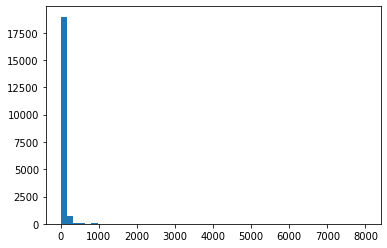

In [7]:
plt.hist(listings["price"], bins=50)
plt.show()

### Remove "extreme" Prices above 500 €

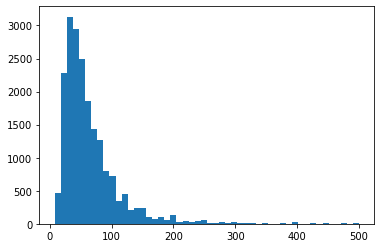

In [8]:
plt.hist(listings[listings["price"] <= 500]["price"], bins=50)
plt.show()

### Take logarithm

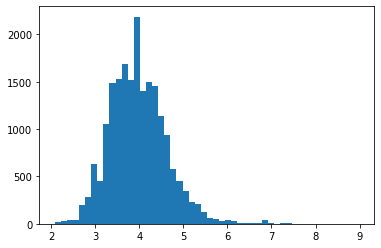

In [9]:
plt.hist(np.log(listings["price"]), bins=50)
plt.show()

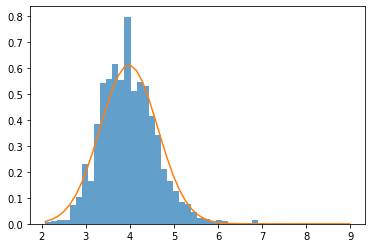

In [10]:
import scipy

_, bins, _ = plt.hist(np.log(listings["price"]), 50, density=1, alpha=0.7)
mu, sigma = scipy.stats.norm.fit(np.log(listings["price"]))
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

# 2.1 Inspect reviews.csv 
Only includes the date of a review -> There might be some valuable information stored in these dates, however we will not take a closer look at these in this notebook, as this are merely dates for the giving listings.

In [11]:
reviews.head()

,listing_id,date
0,1944,2013-09-07
1,1944,2013-09-19
2,1944,2013-10-31
3,1944,2014-03-20
4,1944,2014-07-18


# 3. listings.csv.gz -> Main file
They can also be loaded with pd.read_csv

In [12]:
# @section
listings_meta = pd.read_csv("listings.csv.gz")
reviews_meta = pd.read_csv("reviews.csv.gz")
calendar = pd.read_csv("calendar.csv.gz")

## Inspect listings.csv.gz 
This is the larger listings-file with 74 columns and 19858 observations

In [13]:
listings_meta.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20210312174442,2021-03-14,bright & airy Pberg/Mitte 3 months or more,"Private, bright and friendly room. You'd be sh...",near all the trendy cafés and flea markets and...,https://a0.muscache.com/pictures/107924758/1f4...,2164,https://www.airbnb.com/users/show/2164,...,9.0,9.0,8.0,NaN,f,3,1,2,0,0.20
1,2015,https://www.airbnb.com/rooms/2015,20210312174442,2021-03-20,Berlin-Mitte Value! Quiet courtyard/very central,Great location! <br />30 of 75 sq meters. Thi...,It is located in the former East Berlin area o...,https://a0.muscache.com/pictures/260fd609-710a...,2217,https://www.airbnb.com/users/show/2217,...,10.0,10.0,9.0,NaN,f,6,6,0,0,2.24
2,3176,https://www.airbnb.com/rooms/3176,20210312174442,2021-03-15,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,https://www.airbnb.com/users/show/3718,...,9.0,10.0,9.0,NaN,f,1,1,0,0,1.03
3,3309,https://www.airbnb.com/rooms/3309,20210312174442,2021-03-14,BerlinSpot Schöneberg near KaDeWe,First of all:<br />I prefer short-notice booki...,"My flat is in the middle of West-Berlin, direc...",https://a0.muscache.com/pictures/29054294/b1fa...,4108,https://www.airbnb.com/users/show/4108,...,10.0,9.0,9.0,NaN,f,1,0,1,0,0.29
4,6883,https://www.airbnb.com/rooms/6883,20210312174442,2021-03-20,Stylish East Side Loft in Center with AC & 2 b...,This apartment is available for people working...,The emerging and upcoming East of the new hip ...,https://a0.muscache.com/pictures/06b77d9b-4843...,16149,https://www.airbnb.com/users/show/16149,...,10.0,10.0,10.0,02/Z/RA/008250-18,f,1,1,0,0,1.00


In [14]:
for column in listings_meta.columns:
    print(column)

id
listing_url
scrape_id
last_scraped
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
review_sc

You find a detailed overview over the meanings of all columns on https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

### Adjust price column -> From string to float
In this file, unfortunately, the prices are not stored as integers/floats as in the previous file. Therefore we clean them up

In [15]:
listings_meta["price"] = (
    listings_meta["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

<ipython-input-15-50935869fc24>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  listings_meta["price"].str.replace("$", "").str.replace(",", "").astype(float)


To compute an examplery correlation matrix we must encode the categorized variables we are using. In this caase the room type and the neighbourhood group

In [16]:
# Encode the input Variables
def Encode(airbnb):
    for column in airbnb.columns[
        airbnb.columns.isin(["neighbourhood_group", "room_type"])
    ]:
        airbnb[column] = airbnb[column].factorize()[0]
    return airbnb


airbnb_en = Encode(listings_meta.copy())

## Compute correlation matrix

<AxesSubplot:>

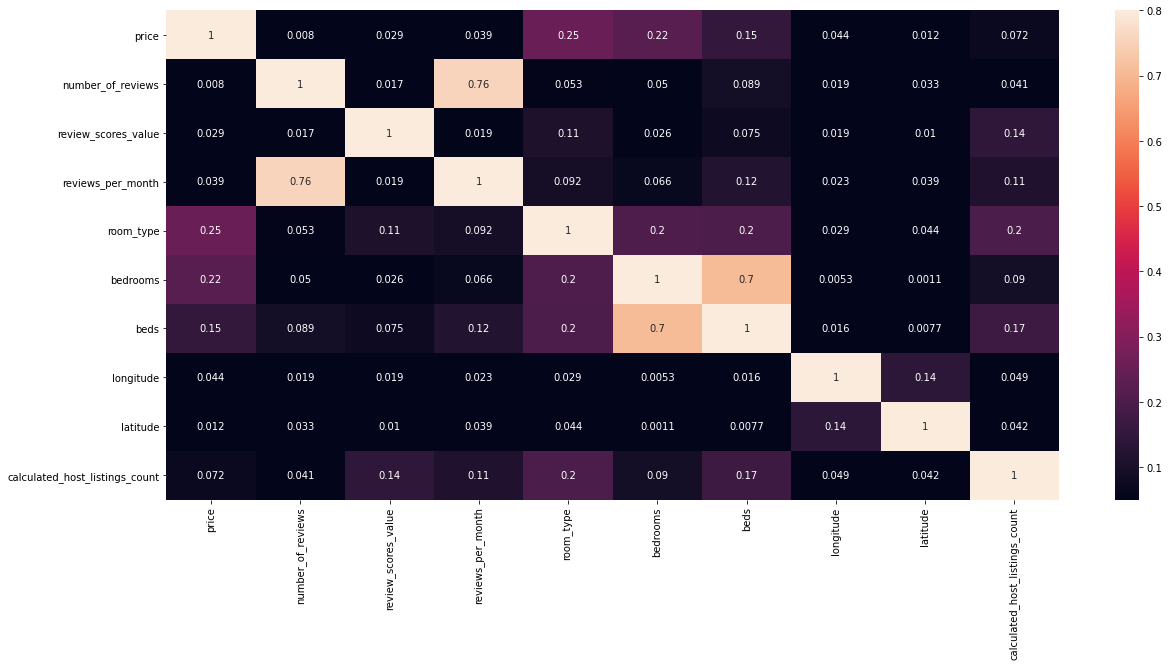

In [17]:
corr_matrix = airbnb_en[
    [
        "price",
        "number_of_reviews",
        "review_scores_value",
        "reviews_per_month",
        "host_response_rate",
        "room_type",
        "bedrooms",
        "beds",
        "longitude",
        "latitude",
        "calculated_host_listings_count",
    ]
].corr()
corr_matrix = abs(corr_matrix)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)

As expected, we are dealing with some correlation between some of the variables used. Be aware that the variables are used randomly and that there could be more meaningful and more variables that correlate with each other. Depending on your model choice, however, this is something you might want to have in mind.

## Analyze longitude and latitude
### Plot all the apartments offered in their location

#### This is specifically for the city of Berlin and you will not be able to run this cell because you do not have the necessary file saved locally. Since it is definitely not necessary for you all to have a .shp file of Berlin, I will not upload these files.
If you want to do this for another city, you will need to download a shp file of the city. 

<AxesSubplot:>

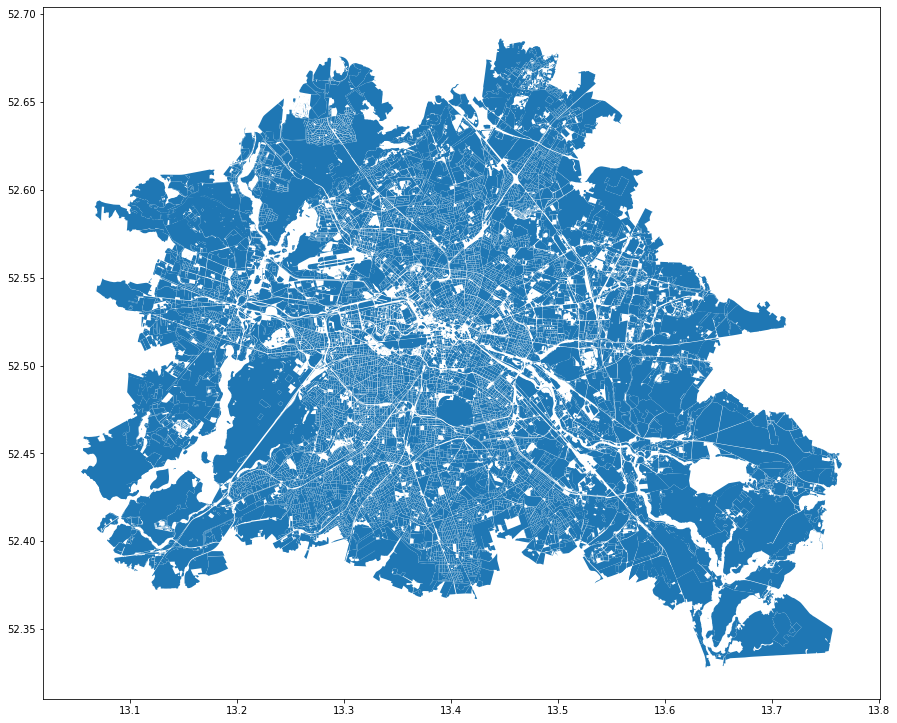

In [18]:
# @section
street_map = gpd.read_file("berlin-latest-free.shp/gis_osm_landuse_a_free_1.shp")
fig, ax = plt.subplots(figsize=(15, 15))
street_map.plot(ax=ax)

In [19]:
geometry = [
    Point(xy) for xy in zip(listings_meta["longitude"], listings_meta["latitude"])
]
geo_df = gpd.GeoDataFrame(listings_meta, crs={"init": "epsg:4326"}, geometry=geometry)

c:\users\anton\desktop\projects\deepdl\deepdl_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


No handles with labels found to put in legend.


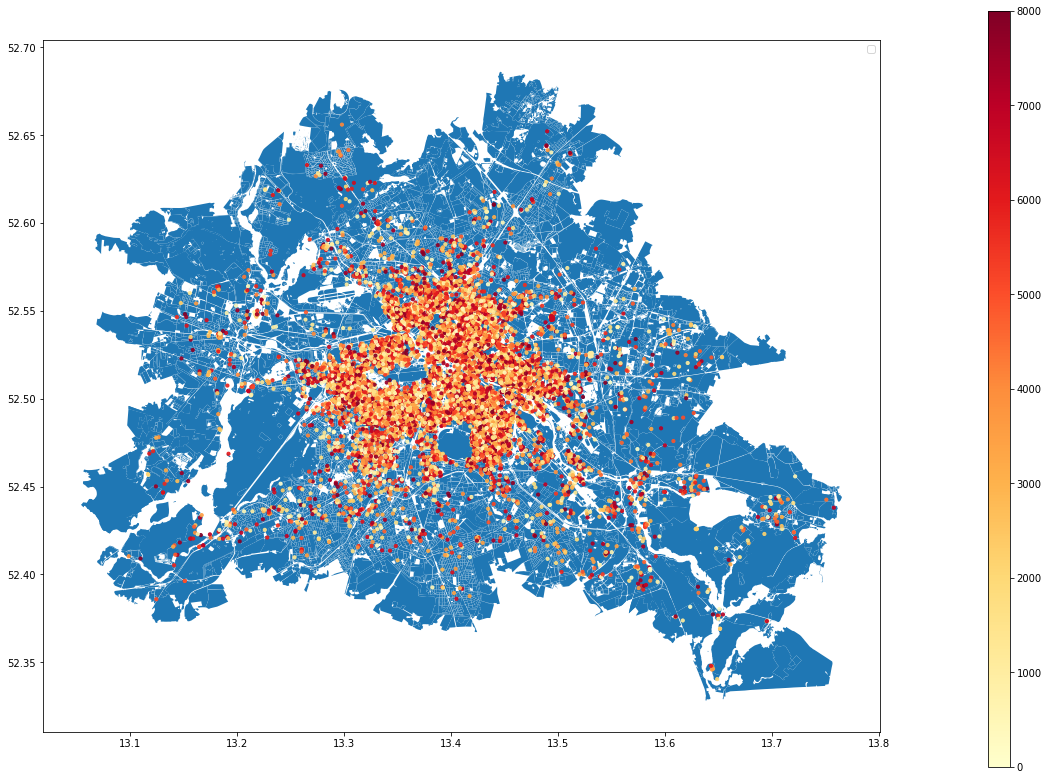

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_facecolor("black")
street_map.plot(ax=ax)
geo_df[geo_df["price"] > 0].plot(
    ax=ax,
    markersize=10,
    c=geo_df["price"],
    cmap=plt.get_cmap("YlOrRd"),
    alpha=0.9,
    zorder=5,
    legend=True,
)
plt.legend()
vmin = geo_df["price"].min()
vmax = geo_df["price"].max()
cax = fig.add_axes([1, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)
plt.show()

## Grouped by their location and the amount of offerings in that area

There is no need to download a map, you just need to adjust the location, which is location=[52.520008, 13.404954] for Berlin 

In [21]:
lats2018 = listings["latitude"].tolist()
lons2018 = listings["longitude"].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.520008, 13.404954], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

# Analyze a single entry

In [22]:
# @section
listings_meta.loc[2][
    [
        "id",
        "host_name",
        "neighbourhood_cleansed",
        "room_type",
        "bedrooms",
        "beds",
        "amenities",
        "price",
        "review_scores_rating",
    ]
]

id                                                                     3176
host_name                                                            Britta
neighbourhood_cleansed                              Prenzlauer Berg Südwest
room_type                                                   Entire home/apt
bedrooms                                                                1.0
beds                                                                    2.0
amenities                 ["Dedicated workspace", "Hangers", "Kitchen", ...
price                                                                  90.0
review_scores_rating                                                   93.0
Name: 2, dtype: object

In [23]:
listings_meta.loc[2]["host_about"]

'We love to travel ourselves a lot and prefer to stay in apartments. Especially since we had a baby .\r\n'

In [24]:
listings_meta.loc[2]["description"]

"This beautiful first floor apartment  is situated at  Kollwitzplatz.<br />Its ideal for 2 but can comfortably accommodate 4 with the extra double bed in the living room.<br /><br />PLEASE INQUIRE FIRST BEFORE MAKING A BOOKING. THANKS<br /><br /><b>The space</b><br />1st floor (68m2) apartment on Kollwitzplatz/ Prenzlauer Berg.<br /><br />It's ideal for 2 but can sleep comfortably an extra 2 in the living room. (Please let us know in advance if you are 2 people sleeping separately that we can bring extra sheet for you.)<br />Kids are welcome and for smaller visitors we can arrange  baby cot and high chair.<br /><br />The front room is spacious and open plain with a large dining table, parquet flooring and a simple yet stylish décor.<br />You can relax in an Indian easy chair or simply lounge on the daybed.<br /><br />The kitchen area has everything from frying pan to coffee maker, an electric oven and stove, refrigerator.<br /><br />To the back of the apartment is the bedroom with a la

# 4. Analyze Images

## Load the image of the host.
### The link is stored in the column "host_picture_url"
#### Scraping is fairly simple, e.g. with "requests.get"

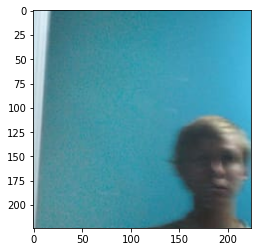

In [25]:
# @section
IMAGE_SIZE = [224, 224]

response = requests.get(listings_meta.loc[2]["host_picture_url"])
img_plot = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
plt.grid(False)
plt.imshow(img_plot)

## For each entry there is also a "picture_url" which is the thumbnail picture
### There are multiple images for each entry but you are not required to include them, as the respective urls are not stored in the dataframe

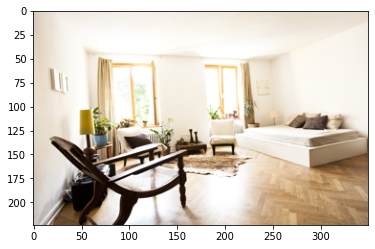

In [26]:
IMAGE_SIZE = [350, 224]

response = requests.get(listings_meta.loc[2]["picture_url"])
img_plot = Image.open(BytesIO(response.content)).resize(IMAGE_SIZE)
plt.grid(False)
plt.imshow(img_plot)

# 5. Analyze the reviews

In [27]:
# @section
reviews_meta.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1944,7126992,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...
1,1944,7428447,2013-09-19,3021574,Rafiee,Very convenient and very quiet. You will stay...
2,1944,8455250,2013-10-31,5875429,Grzegorz,I've spent 2 nights at place of Laura and Emil...
3,1944,11105498,2014-03-20,5361252,Ngọc Thúy,The reservation was canceled 2 days before arr...
4,1944,15920963,2014-07-18,6659444,Nathalie,Laura est très sympathique et l'appartement fa...


## Get all reviews for one entry
 The "listing_id" in the reviews file is the "id" column in the listings file

In [28]:
senti = reviews_meta[reviews_meta["listing_id"] == listings_meta.loc[2]["id"]]
senti

,listing_id,id,date,reviewer_id,reviewer_name,comments
153,3176,4283,2009-06-20,21475,Milan,"excellent stay, i would highly recommend it. a..."
154,3176,134722,2010-11-07,263467,George,Britta's apartment in Berlin is in a great are...
155,3176,144064,2010-11-24,76726,Patricia,"Fantastic, large place in good location. Only ..."
156,3176,156702,2010-12-21,291657,Benedetta,L'appartamento di Britta è molto largo carino ...
157,3176,165048,2011-01-04,279789,Aude,We went in Berlin for the new year eve. The ap...
...,...,...,...,...,...,...
295,3176,138517325,2017-03-20,56885859,Rebecca,"A true gem, spacious, cosy and with a small ba..."
296,3176,342678755,2018-10-29,116711875,Sang Woo,Good
297,3176,476942938,2019-06-27,19156156,Zan,"Britta's place was beautiful and clean, lovely..."
298,3176,626407441,2020-05-27,14043869,Akos,"The place is in an exceptional location, it is..."


## Perform sentiment analysis for these reviews

Use nlptown/bert-base-multilingual-uncased-sentiment as we have reviews in different languages

Just to give you a short idea of the reviews we will perform a simple sentiment analysis on a small subset

In [29]:
classifier = pipeline(
    "sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment"
)

In [30]:
results = []
for i in range(100):
    temp = classifier(senti["comments"].iloc[i])
    results.append(temp)
results[0:10]

[[{'label': '5 stars', 'score': 0.8462902903556824}],
 [{'label': '5 stars', 'score': 0.583137035369873}],
 [{'label': '5 stars', 'score': 0.7847781777381897}],
 [{'label': '5 stars', 'score': 0.4901953935623169}],
 [{'label': '5 stars', 'score': 0.665007472038269}],
 [{'label': '5 stars', 'score': 0.7194699645042419}],
 [{'label': '4 stars', 'score': 0.5440207123756409}],
 [{'label': '5 stars', 'score': 0.7616961002349854}],
 [{'label': '5 stars', 'score': 0.4973703920841217}],
 [{'label': '5 stars', 'score': 0.5814898610115051}]]

In [31]:
# Let's look at one of these reviews. As most of them have *5* stars I would expect to have a highly positive review
senti["comments"].iloc[4]

'We went in Berlin for the new year eve. The appartment of Britta was really amazing, very chic, cool and in a good district !\r\nYou should go there !'

# 6. Inspect the calendar file

In [32]:
# @section
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,64014,2021-03-14,f,$150.00,$150.00,2.0,365.0
1,192050,2021-03-14,f,$48.00,$48.00,183.0,360.0
2,192050,2021-03-15,f,$48.00,$48.00,183.0,360.0
3,192050,2021-03-16,f,$48.00,$48.00,183.0,360.0
4,192050,2021-03-17,f,$48.00,$48.00,183.0,360.0
...,...,...,...,...,...,...,...
7246999,48560799,2022-03-09,f,$140.00,$140.00,90.0,1125.0
7247000,48560799,2022-03-10,f,$140.00,$140.00,90.0,1125.0
7247001,48560799,2022-03-11,f,$140.00,$140.00,90.0,1125.0
7247002,48560799,2022-03-12,f,$140.00,$140.00,90.0,1125.0


# 7. Inspect the neighbourhoods.geojson file

In [33]:
# @section
neighbours = gpd.read_file("neighbourhoods.geojson")
print(neighbours.head())

                               neighbourhood   neighbourhood_group  \
0             Blankenfelde/Niederschönhausen                Pankow   
1                             Helmholtzplatz                Pankow   
2                         Wiesbadener Straße  Charlottenburg-Wilm.   
3  Schmöckwitz/Karolinenhof/Rauchfangswerder    Treptow - Köpenick   
4                                 Müggelheim    Treptow - Köpenick   

                                            geometry  
0  MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...  
1  MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...  
2  MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...  
3  MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...  
4  MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...  


In [34]:
feq = listings[listings_meta["accommodates"] == 2]
feq = feq.groupby("neighbourhood")["price"].mean().sort_values(ascending=True)
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = gpd.read_file("neighbourhoods.geojson")
adam = pd.merge(adam, feq, on="neighbourhood", how="left")
adam.rename(columns={"price": "average_price"}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)
adam = adam.dropna()
adam = adam[adam["average_price"] < 400]

map_dict = adam.set_index("neighbourhood")["average_price"].to_dict()
color_scale = LinearColormap(
    ["yellow", "red"], vmin=min(map_dict.values()), vmax=max(map_dict.values())
)


<ipython-input-34-58df25c5e291>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  feq = listings[listings_meta["accommodates"] == 2]


In [35]:
def get_color(feature):
    value = map_dict.get(feature["properties"]["neighbourhood"])
    return color_scale(value)


map3 = folium.Map(location=[52.520008, 13.404954], zoom_start=11)

In [36]:
folium.GeoJson(
    data=adam,
    name="Berlin",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["neighbourhood", "average_price"], labels=True, sticky=False
    ),
    style_function=lambda feature: {
        "fillColor": get_color(feature),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity": 0.5,
    },
    highlight_function=lambda feature: {
        "weight": 3,
        "fillColor": get_color(feature),
        "fillOpacity": 0.8,
    },
).add_to(map3)
map3